In [1]:
# Import Libraries
# for text preprocessing
import re
# import spacy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
# import numpy for matrix operation
import numpy as np
# Importing Gensim
import gensim
from gensim import corpora  
import pandas as pd

In [2]:
# dataframe = pd.read_csv("./data/social_media/Facebook_Consolidated.csv")
# dataframe

In [3]:
# corpus = list(dataframe["0"])

In [ ]:
# import nltk
# nltk.download('stopwords')

In [ ]:
# # stop words
# stop = set(stopwords.words('english'))

In [ ]:
# # Apply Preprocessing on the Corpus

# # stop words
# stop = set(stopwords.words('english'))

# # punctuation
# exclude = set(string.punctuation)

# # lemmatization
# lemma = WordNetLemmatizer()

# # One function for all the steps:
# def clean(doc):
    
#     # convert text into lower case + split into words
#     stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
   
#     # remove any stop words present
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
   
#     # remove punctuations + normalize the text
#     normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())  
#     return normalized

# # clean data stored in a new list
# clean_corpus = [clean(doc).split() for doc in corpus]

In [4]:
import ast
dataframe = pd.read_csv("./data/preprocessed.csv")
# clean_corpus = dataframe["preprocessed"]
# clean_corpus = [x.strip('][').split(', ') for x in dataframe["preprocessed"]]
# string to list
clean_corpus = [ast.literal_eval(x) for x in dataframe["preprocessed"]]

In [5]:
# where every unique term is assigned an index.
dict_ = corpora.Dictionary(clean_corpus)

In [6]:
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [dict_.doc2bow(i) for i in clean_corpus]

In [7]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(corpus=doc_term_matrix, num_topics=6, id2word = dict_, passes=20, random_state=20, eval_every=None)

# Prints the topics with the indexes: 0,1,2 :
ldamodel.print_topics()
# we need to manually check whethere the topics are different from one another or not
print(ldamodel.print_topics(num_topics=6, num_words=5))

# num_topics mean: how many topics want to extract
# num_words: the number of words that want per topic


[(0, '0.016*"inflation" + 0.010*"people" + 0.010*"philippine" + 0.010*"country" + 0.008*"dont"'), (1, '0.009*"share" + 0.007*"price" + 0.006*"mb" + 0.006*"market" + 0.006*"company"'), (2, '0.027*"yung" + 0.007*"leni" + 0.007*"bilihin" + 0.007*"inflation" + 0.007*"bansa"'), (3, '0.017*"nyo" + 0.010*"bbm" + 0.008*"wala" + 0.008*"inflation" + 0.007*"golden"'), (4, '0.010*"profit" + 0.007*"land" + 0.006*"build" + 0.006*"million" + 0.006*"q2"'), (5, '0.017*"unity" + 0.007*"question" + 0.006*"loan" + 0.005*"bbm" + 0.005*"marcos"')]


In [6]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(model=ldamodel, texts=clean_corpus, dictionary=dict_, coherence="c_v")

coherence_model.get_coherence() 

0.510901809261436

In [7]:
# NOTE: Gensim’s perplexity value is in logarithmic form. To compare with sklearn’s perplexity value np.exp(-1 *gensim.log_perplexity) is used

print(ldamodel.log_perplexity(doc_term_matrix ))
print(np.exp(-1 * ldamodel.log_perplexity(doc_term_matrix )))


-8.549481118559168
5163.983614221804


In [23]:
# Train model with increasing number of topics

limit=32; start=2; step=4


def train_model_with_diff_topicN(dictionary, corpus, texts, limit, start=2, step=3):
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word = dict_, passes=10, random_state=0, eval_every=None)
      model_list.append(model)
   return model_list

all_model_list = train_model_with_diff_topicN(dictionary=dict_, corpus=doc_term_matrix, texts=clean_corpus, limit=limit,start=start, step=step )

In [24]:
# A method for computing different coherence values(c_v, c_npmi, u_mass) of all models with different number of topics. 

from gensim.models import CoherenceModel

def compute_coherence_values(model_list,dictionary,  texts):
   all_coherence_values ={}
   coherence_types = ["c_v", "c_npmi", "u_mass"]
   
   for coherence_type in coherence_types:
      coherence_values = []
      for model in model_list:
         
         coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
         coherence_values.append(coherence_model.get_coherence())
      all_coherence_values[coherence_type] = coherence_values
      
   return all_coherence_values

In [25]:
# Computes for the perplexity values of models with different number of topics

def compute_perplexity_values(model_list, doc_term_matrix):
   perplexity_values = []
   for model in model_list:
      perplexity_values.append(np.exp(-1 * model.log_perplexity(doc_term_matrix )))
     
   return perplexity_values

In [26]:
# A method for computing the pairwise Jaccard Similarity of topN topics from a model. 
from itertools import combinations


def pairwise_jaccard_diversity(topics, topk=10):
    '''
    compute the average pairwise jaccard distance between the topics
 
    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity
          will be computed
   
    Returns
    -------
    pjd: average pairwise jaccard distance
    '''
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count


In [27]:
# Computes for the jaccard similarity values of models with different number of topics

def compute_jaccard_similarity_values(model_list):
   jaccard_scores = []
   for model in model_list:
      all_topics = []
      for i in range(len(model.show_topics())):
         topic = [x[0] for x in model.show_topic(i, topn=6)]
         all_topics.append(topic)
      jaccard_scores.append(pairwise_jaccard_diversity(all_topics, 6))
   
   return jaccard_scores

In [28]:
# A method for computing different coherence values(c_v, c_npmi, u_mass) of all models with different number of topics. 

from gensim.models import CoherenceModel

def compute_coherence_values(model, dictionary,  texts):
   all_coherence_values ={}
   coherence_types = ["c_v", "c_npmi", "u_mass"]
   
   
   coherence_values = []
   for coherence_type in coherence_types:
      coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
      coherence_values.append(coherence_model.get_coherence())
      
   return coherence_values

In [29]:
import concurrent.futures as cf
import itertools

workers = 8
 
all_coherence_values = []
with cf.ThreadPoolExecutor(max_workers=workers) as executor:
    #for n in executor.map(_findmatch, numberlist):
    for n in executor.map(compute_coherence_values, all_model_list, itertools.repeat(dict_), itertools.repeat(clean_corpus)):
        all_coherence_values.append(n)

In [30]:
all_coherence_values_temp = {"c_v":[], "c_npmi":[], "u_mass":[]}
coherence_types = ["c_v", "c_npmi", "u_mass"]
for coherence_values in all_coherence_values:
   for index,coherence_type in enumerate(coherence_types):
      all_coherence_values_temp[coherence_type].append(coherence_values[index])

In [31]:
type(all_coherence_values_temp)

dict

In [32]:
all_perplexity_values= compute_perplexity_values(all_model_list, doc_term_matrix=doc_term_matrix)
all_jaccard_values = compute_jaccard_similarity_values(all_model_list)

In [33]:
all_coherence_values = all_coherence_values_temp

In [45]:
x

[2, 6, 10, 14, 18, 22, 26, 30]

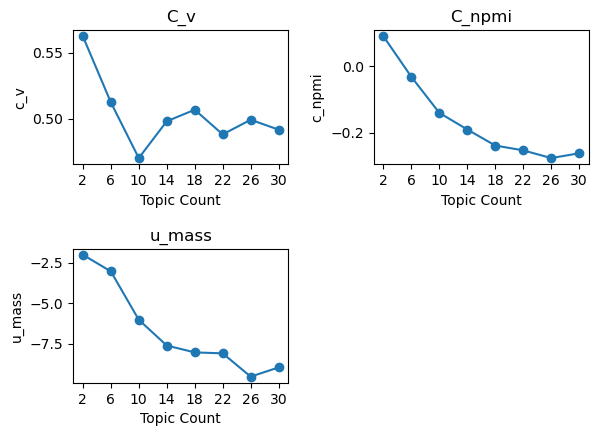

In [52]:
import matplotlib.pyplot as plt

limit=32; start=2; step=4
x =[i for i in range(start, limit, step)]

coherence_types = ["c_v", "c_npmi", "u_mass"]

fig, axs = plt.subplots(2,2)
axs[0,0].plot(np.array(x), np.array(all_coherence_values["c_v"]), marker='o', label="c_v")
axs[0, 0].set_title("C_v")
# axs.xlim(2, 32)
# axs.xlim(xmin=2,xmax=32)
axs[0,1].plot(x, all_coherence_values["c_npmi"], marker='o', label="c_npmi")
axs[0, 1].set_title("C_npmi")
axs[1,0].plot(x, all_coherence_values["u_mass"], marker='o', label="u_mass")
axs[1, 0].set_title("u_mass")
fig.delaxes(axs[1][1])
fig.tight_layout(pad=3.0)

for i,ax in enumerate(axs.flat):
   if i ==3:
      break
   ax.set(xlabel='Topic Count', ylabel=coherence_types[i])
   ax.set_xticks(x)
   ax.set_xticklabels(x)
   

# for coherence_type in coherence_types:
#    ax.plot(x, all_coherence_values[coherence_type], marker='o', label=coherence_type)


Text(0.5, 1.0, 'Perplexity Scores')

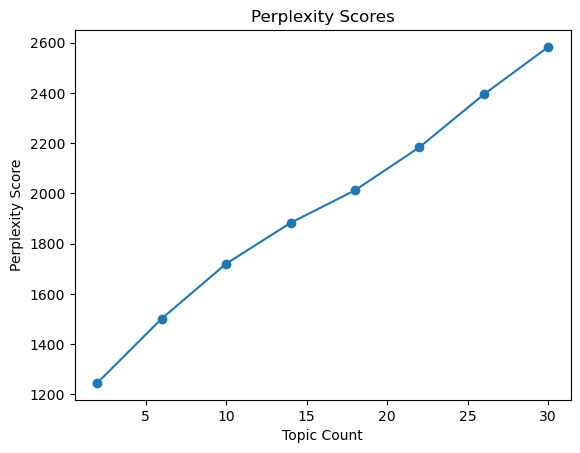

In [ ]:
plt.plot(x,  all_perplexity_values, marker='o')
plt.xlabel('Topic Count')
plt.ylabel('Perplexity Score')
plt.title('Perplexity Scores')


Text(0.5, 1.0, 'Average Pairwise Jaccard Similarity')

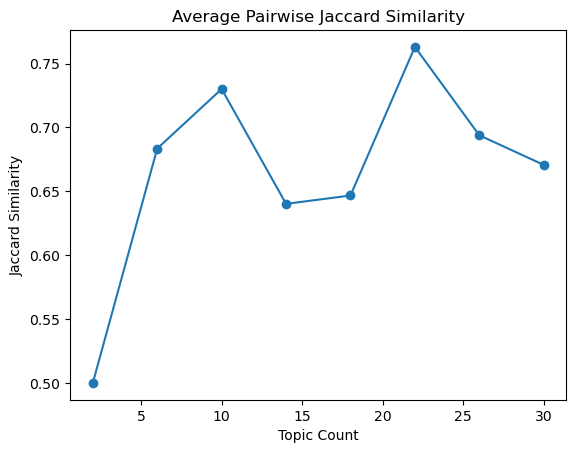

In [ ]:
plt.plot(x,  all_jaccard_values , marker='o')
plt.xlabel('Topic Count')
plt.ylabel('Jaccard Similarity')
plt.title('Average Pairwise Jaccard Similarity')


In [53]:
import pyLDAvis

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
%matplotlib inline

gensimvis.prepare(ldamodel ,doc_term_matrix , dict_)


ModuleNotFoundError: No module named 'pyLDAvis'

In [ ]:
print(doc_topics)

1

In [ ]:
# def conver_topic_score_list_to_topic_score_dict(topic_score_list):
#     out = {}


In [9]:
import numpy as np
all_rows = []
# Get raw scores
for index,doc_in_words in enumerate(clean_corpus):
    doc_in_words_as_string = ' '.join(doc_in_words)
    row_vals = [doc_in_words_as_string]+list(np.zeros(6))
    doc_topics = ldamodel.get_document_topics(doc_term_matrix[index])
    
    # print(doc_in_words_as_string)
    # print(doc_topics)
    for doc_topic in doc_topics:
        row_vals[doc_topic[0]] = doc_topic[1]
    all_rows.append(row_vals)


In [91]:
import pandas as pd
df = pd.DataFrame(all_rows, columns=["Platform","Text"]+[f"Topic {i+1}" for i in range(6)])
df

,Text,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,nowadays every thing seem increasing governanc...,0.000000,0.000000,0.818087,0.144779,0.000000,0.0
1,0.055712,0.055671,0.055614,0.721656,0.055662,0.055686,0.0
2,wag po tayong magalala naniniwala po isusupris...,0.000000,0.000000,0.000000,0.962041,0.000000,0.0
3,0.015158,0.015399,0.015157,0.015284,0.923845,0.015157,0.0
4,0.041686,0.041720,0.041686,0.041686,0.791536,0.041686,0.0
...,...,...,...,...,...,...,...
5204,0.055606,0.056260,0.055606,0.055606,0.721315,0.055607,0.0
5205,0.027898,0.027835,0.027819,0.860761,0.027871,0.027816,0.0
5206,0.055599,0.055599,0.055599,0.055599,0.055599,0.722005,0.0
5207,0.033336,0.384533,0.033336,0.033477,0.481983,0.033336,0.0


In [57]:
# for doc in doc_term_matrix:

for i in range(len(ldamodel.get_topics())):
    print(ldamodel.print_topic(i, topn=30))

[(3, 0.8180868), (4, 0.14477897)]
0.014*"inflation" + 0.011*"price" + 0.008*"rate" + 0.008*"wa" + 0.006*"philippine" + 0.006*"u" + 0.006*"company" + 0.006*"year" + 0.006*"time" + 0.005*"stock" + 0.005*"get" + 0.005*"also" + 0.005*"like" + 0.005*"ha" + 0.004*"billion" + 0.004*"go" + 0.004*"still" + 0.004*"money" + 0.004*"country" + 0.004*"take" + 0.004*"even" + 0.004*"market" + 0.004*"month" + 0.004*"since" + 0.004*"good" + 0.004*"one" + 0.004*"much" + 0.003*"food" + 0.003*"bank" + 0.003*"would"

0.024*"yung" + 0.016*"lang" + 0.011*"kasi" + 0.010*"di" + 0.010*"naman" + 0.008*"mag" + 0.007*"yan" + 0.007*"mo" + 0.007*"si" + 0.007*"nga" + 0.007*"nyo" + 0.007*"k" + 0.007*"talaga" + 0.006*"ba" + 0.006*"nya" + 0.006*"pag" + 0.006*"eh" + 0.006*"nag" + 0.005*"peso" + 0.005*"wala" + 0.005*"sana" + 0.004*"nalang" + 0.004*"bigas" + 0.004*"bilihin" + 0.004*"tapos" + 0.004*"inflation" + 0.004*"gobyerno" + 0.003*"wag" + 0.003*"yun" + 0.003*"araw"

0.015*"share" + 0.011*"mb" + 0.007*"pse" + 0.006*"ipo